In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
from math import *
import seaborn as sns
#from mpl_toolkits.basemap import Basemap

### Malpractice Data:

In [2]:
data = pd.read_csv('NpdbPublicUseDataCsv/NPDB1710.CSV',delimiter=',',low_memory=False)

In [3]:
## Clean the payment column so it's numeric:
data["PAYMENT"].replace('[\$,]', '', regex=True, inplace=True)

In [4]:
data["TOTALPMT"].replace('[\$,]', '', regex=True, inplace=True)

In [5]:
data["FUNDPYMT"].replace('[\$,]', '', regex=True, inplace=True)

In [6]:
data.columns

Index(['SEQNO', 'RECTYPE', 'REPTYPE', 'ORIGYEAR', 'WORKSTAT', 'WORKCTRY',
       'HOMESTAT', 'HOMECTRY', 'LICNSTAT', 'LICNFELD', 'PRACTAGE', 'GRAD',
       'ALGNNATR', 'ALEGATN1', 'ALEGATN2', 'OUTCOME', 'MALYEAR1', 'MALYEAR2',
       'PAYMENT', 'TOTALPMT', 'PAYNUMBR', 'NUMBPRSN', 'PAYTYPE', 'PYRRLTNS',
       'PTAGE', 'PTGENDER', 'PTTYPE', 'AAYEAR', 'AACLASS1', 'AACLASS2',
       'AACLASS3', 'AACLASS4', 'AACLASS5', 'BASISCD1', 'BASISCD2', 'BASISCD3',
       'BASISCD4', 'BASISCD5', 'AALENTYP', 'AALENGTH', 'AAEFYEAR', 'AASIGYR',
       'TYPE', 'PRACTNUM', 'ACCRRPTS', 'NPMALRPT', 'NPLICRPT', 'NPCLPRPT',
       'NPPSMRPT', 'NPDEARPT', 'NPEXCRPT', 'NPGARPT', 'NPCTMRPT', 'FUNDPYMT'],
      dtype='object')

### Census/States Data:

In [7]:
state_pop = pd.read_excel('nst-est2016-01.xlsx',header=3,skip_footer=5)

new_index_list = {}
for s_label in state_pop.index:
    try:
        if s_label[0]=='.':
            new_index_list.update({s_label: s_label[1:]})
        else:
            new_index_list.update({s_label: s_label})
    except:
        new_index_list.update({s_label: 'unknown'})

state_pop.rename(new_index_list, axis='index',inplace=True)

In [8]:
#state_pop

### Some preliminary analysis:

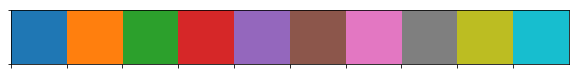

In [9]:
#sns.set_style("ticks")
current_palette = sns.color_palette()
current_palette[0]
sns.palplot(current_palette)


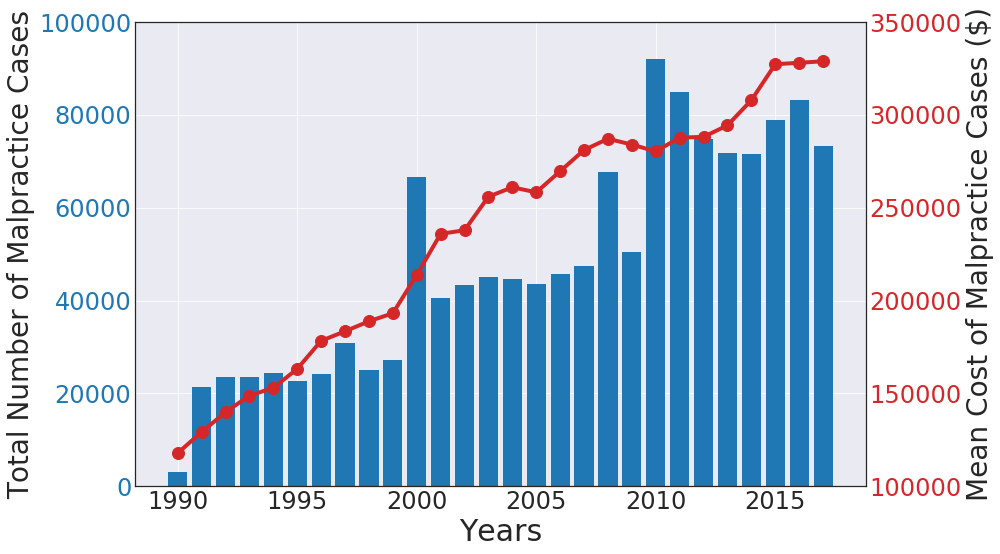

In [102]:
sns.set_style("darkgrid")

fig, ax1 = plt.subplots(figsize=(14,8))

ax1.bar(range(1990,2018),[len(data[data['ORIGYEAR']==year]) for year in range(1990,2018)],color=current_palette[0])
ax1.set_xlabel('Years',fontsize=30)
ax1.tick_params(axis='x',labelsize=24)
ax1.set_ylabel('Total Number of Malpractice Cases',fontsize=28)
ax1.tick_params(axis='y',labelsize=24,labelcolor=current_palette[0])
ax1.set_ylim(0,100000)



sns.set_style("white")
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(range(1990,2018),
        [pd.to_numeric(data[data['ORIGYEAR']==year]['PAYMENT']).mean(skipna=True) for year in range(1990,2018)],
         color=current_palette[3],marker='o',markersize=12,linewidth=4)
ax2.set_ylabel('Mean Cost of Malpractice Cases ($)',fontsize=28)
ax2.tick_params(axis='y',labelsize=24,labelcolor=current_palette[3])
ax2.set_ylim(100000,350000)


fig.tight_layout()
#sns.despine()

plt.savefig('total_numbers_costs_across_us.jpg',dpi=100)
plt.show()

plt.bar(range(1990,2018),
        [pd.to_numeric(data[data['ORIGYEAR']==year]['FUNDPYMT']).mean(skipna=True) for year in range(1990,2018)],
        yerr=[pd.to_numeric(data[data['ORIGYEAR']==year]['FUNDPYMT']).sem(skipna=True) for year in range(1990,2018)])
plt.xlabel('Years')
plt.ylabel('State Payments for Malpractice Cases Across the US')
plt.tight_layout()
plt.savefig('fund_pymt_across_us.png',dpi=300)
plt.show()

data.hist(column='ORIGYEAR',bins=2018-1990,range=(1990,2018),alpha=0.5,by='WORKSTAT',figsize=(20,40),layout=(13,5))
plt.xlabel('Years')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.savefig('total_per_state.png',dpi=300)
plt.show()

### Find states common to census data and malpractice data:

In [11]:
common_states = np.intersect1d(list(data["WORKSTAT"].unique()),list(state_pop["State Abb"]))

In [12]:
print(common_states,len(common_states))

['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'PR' 'RI' 'SC'
 'SD' 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY'] 52


In [13]:
print(state_pop[state_pop["State Abb"]=="CA"][2016][0])
print(state_pop[state_pop["State Abb"]=="NY"][2016][0])
print(state_pop[state_pop["State Abb"]=="PA"][2016][0])

39250017
19745289
12784227


### We start clustering analysis for the common_states in the data:

In [14]:
pay_count = None
for state in common_states:
    #print(state)
    arrays = [[state,state], ['pay_per_case', 'count_per_1000000']]
    column_names = pd.MultiIndex.from_arrays(arrays).T
    mean_payment = [pd.to_numeric(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)]['PAYMENT']).mean() for i in range(1990,2018)]
    count_per_capita = [1000000*len(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)])/state_pop[state_pop["State Abb"]==state][2016][0] for i in range(1990,2018)]
    stack = pd.DataFrame(np.stack((mean_payment,
                                   count_per_capita),axis=0).T,
                         columns=column_names,
                         index=range(1990,2018))
    #print(stack)
    if type(pay_count)==None:
        pay_count = stack
    else:
        pay_count = pd.concat([pay_count, stack], axis=1)

In [15]:
pay_count

AK                               AL                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990            NaN          1.347901  166966.666667          4.112434   
1991  196140.625000         41.784945  121558.333333         23.646495   
1992  105808.333333         59.307664  217455.555556         23.440873   
1993  130986.764706         67.395073  230903.448276         26.525199   
1994   85071.428571         59.307664  254741.666667         24.468982   
1995  178137.500000         43.132846  281157.894737         25.497090   
1996  151242.857143         52.568157  405196.236559         25.291469   
1997  158375.000000         36.393339  225808.988764         28.581416   
1998  286718.750000         52.568157  296460.674157         31.871363   
1999  270546.296296         94.353102  274947.887324         30.637633   
2000  159310.344828        172.531386  367873.529412        330.434067   
2001  240925.000000         48.524452  244472.727273        116.998746   
2002  210240.384615         40.437044  233686.781609        137.355294   
2003  241908.333333         57.959762  212584.027778        137.766537   
2004  189822.000000         47.176551  211181.818182        154.421895   
2005  737932.692308         48.524452  223898.305085        163.058006   
2006  187931.818182         44.480748  281934.375000        179.096498   
2007  482916.666667         33.697536  182864.912281        179.918985   
2008  193289.473684         44.480748  310454.545455         67.443917   
2009  229140.625000         40.437044  306960.000000         42.152448   
2010  615511.904762         51.220255  282437.500000        204.593589   
2011  419333.333333         53.916058  250020.833333        190.611313   
2012  361029.411765         49.872354  317812.500000         82.043057   
2013  289482.142857         62.003467  454377.659574         45.236773   
2014  270666.666667         78.178284  637780.172414         41.124339   
2015  334264.705882         60.655565  308533.653846         53.256020   
2016  208750.000000         47.176551  426599.000000         49.966072   
2017  251363.636364         62.003467  402366.071429         56.957210   

                 AR                               AZ                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990   81357.142857          6.023596  166171.250000          6.203947   
1991   83832.258065         39.488021  122601.452282         47.178856   
1992  226307.065217         39.822665  181994.117647         58.143972   
1993  126375.000000         37.145511  111253.600000         57.134027   
1994  116544.871795         32.795136  155957.993197         64.347920   
1995  107418.354430         35.806934  183279.904306         61.029529   
1996  105860.000000         36.476223  134880.930931         79.352816   
1997   96891.791045         35.472290  230950.825083         67.233477   
1998  178015.789474         49.861993  164200.390625         54.248470   
1999  187451.219512         41.495887  182063.586957         69.253366   
2000  225487.654321         80.314619  231539.655172        138.651011   
2001  169092.233010         67.263494  257575.301205        104.745717   
2002  226741.818182         65.590272  254643.769968        102.870105   
2003  326037.974684         71.948513  274889.041096        107.486996   
2004  261940.229885         38.484088  291361.991870        102.148716   
2005  295718.085106         37.480156  273618.580060         91.327877   
2006  213264.492754         33.464425  253462.264151        147.884793   
2007  259293.103448         31.456559  313289.676113        100.994493   
2008  319433.035714         29.448694  327817.073171        104.889995   
2009  330504.098361         36.476223  295964.508929         95.656212   
2010  291380.434783         32.125848  263381.909548         97.387547   
2011  304291.666667         53.208435  311558.849558        114.556610   
2012  252745.833333 

In [16]:
state_slope = []
for state in common_states:
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(range(1991,2018),
                                                                      pay_count[state,"count_per_1000000"][1:])
    state_slope.append([state,slope,intercept])
    
df_state_slope=pd.DataFrame(state_slope,columns=["state","slope","intercept"])
#df_state_slope #.sort_values("slope")

In [17]:
correlation_slope = np.zeros((len(common_states),len(common_states)))

for state1 in range(len(common_states)):
    for state2 in range(len(common_states)):
        #print(float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"]))
        #print(float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"]))
        #correlation_slope[state1,state2] = np.sqrt(((
        #    float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"])-
        #    float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"])))**2)
        correlation_slope[state1,state2] = ((
            float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"])-
            float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"])))**2

In [18]:
#print(correlation_slope)

In [19]:
from sklearn.cluster import DBSCAN
# Compute DBSCAN

db = DBSCAN(eps=0.05, min_samples=1,metric='precomputed').fit_predict(correlation_slope)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
#for i in np.unique(db):
#    print(i,common_states[np.where(db==i)])
    
df_state_cluster = pd.DataFrame(db.T,columns=["cluster"])
df_state_slope_cluster = pd.concat([df_state_slope,df_state_cluster],axis=1)

average_slopes = []
for state in common_states:
    current_cluster = int(df_state_slope_cluster[df_state_slope_cluster["state"]==state]["cluster"])
    #print(current_cluster)
    average_slope = df_state_slope_cluster[df_state_slope_cluster["cluster"]==current_cluster]["slope"].mean()
    average_slopes.append(average_slope)
    
df_cluster_slope = pd.DataFrame(np.array(average_slopes).T,columns=["avg_slopes"])
df_state_slope_cluster_aslope = pd.concat([df_state_slope_cluster,df_cluster_slope],axis=1)

cluster_colors = pd.DataFrame(np.array(average_slopes).T,columns=["cl_colors"])
df_state_slope_cluster_aslope_acolor = pd.concat([df_state_slope_cluster_aslope,cluster_colors],axis=1)

start = 0
for i in np.unique(df_state_slope_cluster_aslope["avg_slopes"].sort_values()):
    #print(i)
    #print(start)
    df_state_slope_cluster_aslope_acolor.replace(to_replace= {'cl_colors': {i: start}}, inplace=True)
    start += 1

In [20]:
#df_state_slope_cluster_aslope_acolor

for i in range(len(np.unique(db))):
    print("CLUSTER "+str(i))
    data[data["WORKSTAT"].isin(list(common_states[np.where(db==i)]))].hist(column='ORIGYEAR',bins=2018-1990,range=(1990,2018),alpha=0.5,by='WORKSTAT',figsize=(20,60),layout=(20,3))
    plt.show()

In [21]:
from bokeh.io import show, save, output_notebook, export_png
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    ContinuousColorMapper,
    LabelSet,
    Label,
    LogColorMapper, 
    LogTicker, 
    FixedTicker,
    ColorBar, 
    LinearColorMapper,
    Legend
)
from bokeh.plotting import figure, output_file, show
## This is where we get the state data from:
from bokeh.sampledata.us_states import data as states
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.palettes import PRGn11 as palette
from bokeh.palettes import Category20,Spectral11,Category10,PRGn11

In [22]:
try:
    del states["HI"]
    del states["AK"]
except:
    pass

#palette.reverse()

states = {
    code: state for code, state in states.items()
}
#print(states)

state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]
state_names = [state['name'] for state in states.values()]

state_rates = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_rates.append(float(df_state_slope[df_state_slope["state"]==abbr]["slope"]))
    
state_abbr = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_abbr.append(abbr)
    
#print(state_rates)

lat_inkm = 111.132 ## at around lat = 45degrees from the wiki latitude page
lon_inkm = 78.847 ## at around lat = 45degrees from the wiki latitude page

In [23]:
text_position_x = []
for statex in state_xs:
    text_position_x.append(float("%.5f" % round(max(statex)-(max(statex)-min(statex))/2,5)))
    
text_position_y = []
for statey in state_ys:
    text_position_y.append(float("%.5f" % round(max(statey)-(max(statey)-min(statey))/2,5)))

In [24]:
state_clusters=[]
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_clusters.append(palette[int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["state"]==abbr]["cl_colors"])])

#state_clusters

In [25]:
cluster_label = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    cluster_label.append(int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["state"]==abbr]["cl_colors"])+1)

#cluster_label

In [26]:
import pickle
print(pickle.compatible_formats)

['1.0', '1.1', '1.2', '1.3', '2.0', '3.0', '4.0']


In [27]:
#state_xs

In [28]:
pickle.dump(state_xs, open("state_xs.pck", "wb"))
pickle.dump(state_ys, open("state_ys.pck", "wb"))
pickle.dump(state_names, open("state_names.pck", "wb"))
pickle.dump(state_rates, open("state_rates.pck", "wb"))
pickle.dump(state_clusters, open("state_clusters.pck", "wb"))
pickle.dump(cluster_label, open("cluster_label.pck", "wb"))

state_xs = pickle.load(open("state_xs.pck", "rb"))
state_ys = pickle.load(open("state_ys.pck", "rb"))
state_names = pickle.load(open("state_names.pck", "rb"))
state_rates = pickle.load(open("state_rates.pck", "rb"))
state_clusters = pickle.load(open("state_clusters.pck", "rb"))
cluster_label = pickle.load(open("cluster_label.pck", "rb"))

In [29]:
output_notebook()

color_mapper = LinearColorMapper(palette=palette) #, low=min(state_rates), high=max(np.unique(state_rates)))

source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    name=state_names,
    rate=state_rates,
    clusters=state_clusters,
    cluster_label=cluster_label,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(title="Change in the number of malpractice cases filed per a million citizens per states, 1990-2018", 
    plot_width=int((max(max(state_xs))-min(min(state_xs)))*lon_inkm/4.5), 
    plot_height=int((max(max(state_ys))-min(min(state_ys)))*lat_inkm/4.5), tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)

p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color='clusters',
          fill_alpha=0.7, line_color="gray", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, #ticker=FixedTicker(ticks=np.unique(cluster_label)),
                     label_standoff=12, border_line_color=None, location=(0,0),major_label_text_font_size="14pt")

p.add_layout(color_bar, 'right')

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips ="""
    <font size="3">State: <strong>@name</strong> </font> <br>
    <font size="3">Change in the number of   </font> <br>
    <font size="3">malpractice cases: <strong>@rate per 1,000,000</strong> </font> <br>
    <font size="3">Ranking: <strong>@cluster_label</strong> </font>
"""
show(p)

#output_file("malpractice_by_state.html",title="Malpractice by state")
#save(p, filename="malpractice_by_state.html", title="Malpractice by state", resource='cdn')


Loading BokehJS ...

In [30]:
pickle.dump(df_state_slope_cluster_aslope_acolor, open("df_state_slope_cluster_aslope_acolor.pck", "wb"))
pickle.dump(pay_count, open("pay_count.pck", "wb"))

df_state_slope_cluster_aslope_acolor = pickle.load(open("df_state_slope_cluster_aslope_acolor.pck", "rb"))
pay_count = pickle.load(open("pay_count.pck", "rb"))

In [100]:
def create_plot(state):
    print(state)
    p = figure(plot_width=450, plot_height=450, x_axis_label='Years', y_axis_label='Malpractice cases filed per 1,000,000')
    rank = int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor['state']==state]['cl_colors'])
    cur_states = list(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["cl_colors"]==rank]["state"])
    states_title = str()
    #print(cur_states)
    for x in cur_states:
        states_title = states_title+x+', '
    if len(cur_states)>8:
        sel_states = list(np.random.choice(cur_states,size=8,replace=False))
        sel_states.sort()
        if state in sel_states:
            sel_states.pop(sel_states.index(state))
            cur_states = [state]+sel_states
            print('if',cur_states)
        else:
            cur_states = [state]+sel_states[:7]
            print('else',cur_states)
        states_title = str()
        for x in cur_states:
            states_title = states_title+x+', '
        p.title.text = states_title[:-2]+" among others (Ranking "+str(rank)+")."
    else:
        p.title.text = states_title[:-2]+" (Ranking "+str(rank)+")."
    
    for state_, color in zip(cur_states, Category20[20]):
        curve = pay_count[state_,"count_per_1000000"]
        #plt.plot(range(1990,2018),curve,label=state,marker='.')
        r = p.line(curve.index, curve,line_width=2, color=color, alpha=1.,
                   muted_color=color, muted_alpha=0.2, legend=state_)
        if state_!=state:
            r.muted=True
    p.legend.location = "top_right"
    p.legend.click_policy="mute"
    return(p)

#rank = int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor['state']=='AK']['cl_colors'])
#print(rank)
plot_mini = create_plot("CT")
show(plot_mini)

CT
else ['CT', 'AK', 'IA', 'KY', 'MD', 'NJ', 'SC', 'TX']


In [68]:
alist = ['UT', 'SD', 'RI', 'IN', 'FL', 'CA', 'NJ', 'TN']
alist.sort()
alist[:7]

['CA', 'FL', 'IN', 'NJ', 'RI', 'SD', 'TN']

In [39]:
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Select
from bokeh.plotting import Figure, output_file, show
from bokeh.layouts import column, gridplot

output_file("js_on_change.html")

def create_plot(ranking):
    p = figure(plot_width=450, plot_height=450, x_axis_label='Years', y_axis_label='Malpractice cases filed per 1,000,000')
    cur_states = list(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["cl_colors"]==ranking]["state"])
    states_title = str()
    for x in cur_states:
        states_title = states_title+x+', '
    
    if len(cur_states)>8:
        cur_states = np.random.choice(cur_states,size=8,replace=False)
        states_title = str()
        for x in cur_states:
            states_title = states_title+x+', '
        p.title.text = states_title[:-2]+" among others (Ranking "+str(ranking)+")."
    else:
        p.title.text = states_title[:-2]+" (Ranking "+str(ranking)+")."
    
    for state, color in zip(cur_states, Category20[20]):
        curve = pay_count[state,"count_per_1000000"]
        #plt.plot(range(1990,2018),curve,label=state,marker='.')
        p.line(curve.index, curve,line_width=2, color=color, alpha=1.,
               muted_color=color, muted_alpha=0.2, legend=state)
    p.legend.location = "top_right"
    p.legend.click_policy="mute"
    return(p)



plot0 = create_plot(ranking=0)
plot1 = create_plot(ranking=1)

plot2 = create_plot(ranking=2)
plot3 = create_plot(ranking=3)


plot4 = create_plot(ranking=4)
plot5 = create_plot(ranking=5)


plot6 = create_plot(ranking=6)
plot7 = create_plot(ranking=7)


plot8 = create_plot(ranking=8)
plot9 = create_plot(ranking=9)


plot10 = create_plot(ranking=10)

#plot = gridplot([plot0,plot1],[plot2,plot3],[plot4,plot5],[plot6,plot7],[plot8,plot9],[plot10,None])
plot = gridplot([plot0,plot1,plot2],[plot3,plot4,plot5],[plot6,plot7,plot8],[plot9,plot10,None])
show(plot)

In [34]:
non_existent = ["AL", "AK", "AZ", "AR", "DE", "GA", "HI", "ID", "IA", "KY", "LA", "MS", 
                "MO", "MT", "NH", "NM", "NC", "ND", "OK", "SD", "VA", "WV", "WI"] 
mandatory = ["CA", "CO", "CT", "DC", "FL", "IL", "IN", "KS", "ME", "MD", "MA", "MN", 
             "NV", "NJ", "NY", "OH", "PA", "RI", "SC", "TN", "TX", "UT", "VT", "WA"]
partial = ["OR", "WY"]
#no_info = ["PR"]
self_organized = ["MI"]
voluntary = ["NE"]

In [35]:
#df_state_slope_cluster_aslope_acolor["state"]

In [36]:
ordered_mandatory = []
for state in list(df_state_slope_cluster_aslope_acolor["state"]):
    #print(state)
    if state in non_existent:
        ordered_mandatory.append('No')
    elif state in mandatory:
        ordered_mandatory.append('Yes')
    elif state in partial:
        ordered_mandatory.append('Partially')
    elif state in voluntary:
        ordered_mandatory.append('Voluntary')
    elif state in self_organized:
        ordered_mandatory.append('Self Org.')
    #elif state in no_info:
    #    ordered_mandatory.append('NA')
    else:
        print("ERROR")

ERROR


In [37]:
#ordered_mandatory

plt.scatter(ordered_mandatory,list(df_state_slope_cluster_aslope_acolor["slope"].drop([39])), marker='o')
plt.show()

In [38]:
slope_mandatory = pd.DataFrame(np.stack([np.array(df_state_slope_cluster_aslope_acolor["state"].drop([39])),
                                         np.array(df_state_slope_cluster_aslope_acolor["slope"].drop([39])), 
                                         np.array(df_state_slope_cluster_aslope_acolor["cl_colors"].drop([39])),
                                         np.array(ordered_mandatory)]).T, columns=['state','slope',"ranking","mandatory"])

In [39]:
#slope_mandatory

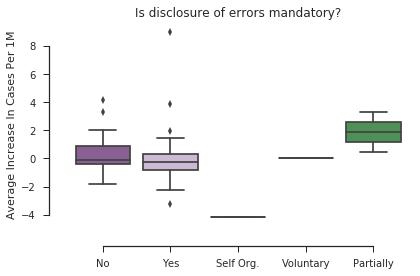

In [40]:
import seaborn as sns
sns.set(style="ticks")

sns.boxplot(x=np.array(ordered_mandatory), 
            y=np.array(df_state_slope_cluster_aslope_acolor["slope"].drop([39])), 
            palette="PRGn", width=0.8)

sns.despine(offset=20, trim=True)
plt.title("Is disclosure of errors mandatory?")
plt.ylabel("Average Increase In Cases Per 1M") #,fontsize=14)
plt.tight_layout()
plt.savefig("Mandatory.png",dpi=300)

## Most problematic license fields:

In [41]:
#data

In [44]:
licnfeld = pd.read_csv('license_fields.csv',delimiter=',',low_memory=False)[["Value","Label"]]
licnfeld_dict = licnfeld.to_dict(orient='split')
#np.array(licnfeld_dict['data'])

In [52]:
licnfeld_dict

{'columns': ['Value', 'Label'],
 'data': [[10, 'Allopathic Physician (MD)'],
  [15, 'Physician Resident (MD)'],
  [20, 'Osteopathic Physician (DO)'],
  [25, 'Osteopathic Physician Resident (DO)'],
  [30, 'Dentist'],
  [35, 'Dental Resident'],
  [50, 'Pharmacist'],
  [55, 'Pharmacy Intern '],
  [60, 'Pharmacist, Nuclear'],
  [70, 'Pharmacy Assistant'],
  [75, 'Pharmacy Technician '],
  [76, 'Other Pharmacy Service Occupation'],
  [100, 'Registered Nurse'],
  [110, 'Nurse Anesthetist'],
  [120, 'Nurse Midwife'],
  [130, 'Nurse Practitioner'],
  [134, 'Doctor of Nursing Practice '],
  [135, 'Advanced Nurse Practitioner '],
  [140, 'LPN or Vocational Nurse'],
  [141, 'Clinical Nurse Specialist '],
  [142, 'Other Nurse Occupation'],
  [148, 'Certified Nurse Aide/Nursing Assistant '],
  [150, 'Nurse Aide/Nursing Assistant'],
  [160, 'Home Health Aide (Homemaker)'],
  [165, 'Health Care Aide/Direct Care Worker '],
  [170, 'Psychiatric Technician'],
  [175, 'Certified or Qualified Medication A

In [45]:
dict_fin = {}
for element in licnfeld_dict['data']:
    dict_fin[element[0]] = element[1]

#print(dict_fin)

In [46]:
clustering_data = data.copy()
clustering_data.replace(to_replace= {'LICNFELD': dict_fin}, inplace=True)

In [47]:
#clustering_data["LICNFELD"]

clustering_data.hist(column='LICNFELD',alpha=0.5,by='WORKSTAT',figsize=(20,40),layout=(13,5))
plt.xlabel('License')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.savefig('Licenses.png',dpi=300)
plt.show()

plt.figure(figsize=(20,10))
clustering_data['LICNFELD'].hist(bins=xrot=90)
plt.xlabel('License')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.savefig('Licenses.png',dpi=300)
plt.show()

In [48]:
#np.unique(clustering_data['LICNFELD'])

In [49]:
#pickle.dump(clustering_data[["LICNFELD","WORKSTAT"]], open("clustering_data.pck", "wb"))

In [50]:
def license_bar_plot(df,upto=20,save=None):
    lic_list = []
    count = []
    for license in np.unique(df['LICNFELD']):
        lic_list.append(license)
        count.append(len(df[df['LICNFELD']==license]))
    lic_count = pd.DataFrame(np.array(count).T,columns=['count'],index=lic_list)
    lic_count.sort_values('count',inplace=True,ascending=False)
    lic_count[:upto].plot(kind='bar',figsize=(20,10))
    if save!=None:
        plt.savefig(save, dpi=300)
    plt.show()
    return lic_count

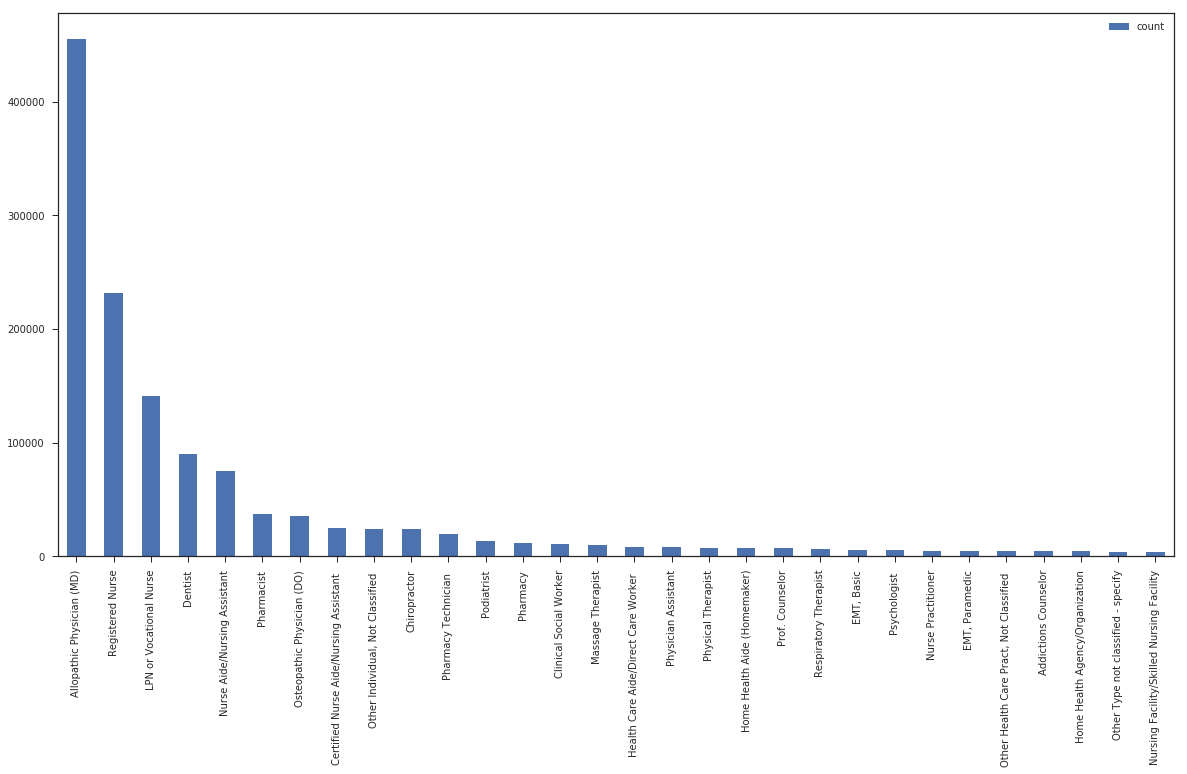

,count
Allopathic Physician (MD),455433
Registered Nurse,231925
LPN or Vocational Nurse,140851
Dentist,89638
Nurse Aide/Nursing Assistant,75341
Pharmacist,37316
Osteopathic Physician (DO),35880
Certified Nurse Aide/Nursing Assistant,25024
"Other Individual, Not Classified",23878
Chiropractor,23819


In [51]:
license_bar_plot(clustering_data,upto=30,save="risky_fields.png")

In [43]:
#lic_count_MI = license_bar_plot(clustering_data[clustering_data['WORKSTAT']=="MI"][["LICNFELD","WORKSTAT"]],upto=30)

In [44]:
#lic_count_MI.index

In [45]:
#list(lic_count_MI.index)[:10]

from bokeh.io import output_file, show
from bokeh.sampledata.autompg import autompg as df

p = figure(plot_width=450, plot_height=450)

p.vbar(x=list(lic_count_MI.index)[:10], width=0.5, bottom=0, top=list(lic_count_MI["count"])[:10], color="#CAB2D6")

output_file("bar.html")

show(p)

In [53]:
data.columns

Index(['SEQNO', 'RECTYPE', 'REPTYPE', 'ORIGYEAR', 'WORKSTAT', 'WORKCTRY',
       'HOMESTAT', 'HOMECTRY', 'LICNSTAT', 'LICNFELD', 'PRACTAGE', 'GRAD',
       'ALGNNATR', 'ALEGATN1', 'ALEGATN2', 'OUTCOME', 'MALYEAR1', 'MALYEAR2',
       'PAYMENT', 'TOTALPMT', 'PAYNUMBR', 'NUMBPRSN', 'PAYTYPE', 'PYRRLTNS',
       'PTAGE', 'PTGENDER', 'PTTYPE', 'AAYEAR', 'AACLASS1', 'AACLASS2',
       'AACLASS3', 'AACLASS4', 'AACLASS5', 'BASISCD1', 'BASISCD2', 'BASISCD3',
       'BASISCD4', 'BASISCD5', 'AALENTYP', 'AALENGTH', 'AAEFYEAR', 'AASIGYR',
       'TYPE', 'PRACTNUM', 'ACCRRPTS', 'NPMALRPT', 'NPLICRPT', 'NPCLPRPT',
       'NPPSMRPT', 'NPDEARPT', 'NPEXCRPT', 'NPGARPT', 'NPCTMRPT', 'FUNDPYMT'],
      dtype='object')

In [86]:
data[data['HOMECTRY'].notna()]

,SEQNO,RECTYPE,REPTYPE,ORIGYEAR,WORKSTAT,WORKCTRY,HOMESTAT,HOMECTRY,LICNSTAT,LICNFELD,...,ACCRRPTS,NPMALRPT,NPLICRPT,NPCLPRPT,NPPSMRPT,NPDEARPT,NPEXCRPT,NPGARPT,NPCTMRPT,FUNDPYMT


In [78]:
np.nan==np.nan

False

fig, ax1 = plt.subplots(figsize=(14,8))

ax1.bar(range(1990,2018),[len(data[data['ORIGYEAR']==year]) for year in range(1990,2018)],color=current_palette[0])
ax1.set_xlabel('Years',fontsize=30)
ax1.tick_params(axis='x',labelsize=24)
ax1.set_ylabel('Total Number of Malpractice Cases',fontsize=28)
ax1.tick_params(axis='y',labelsize=24,labelcolor=current_palette[0])
ax1.set_ylim(0,100000)